# Reciprocal data analysis of field ERT data

According to the principle of reciprocity, the measured resistance of four-point
arrays does not change if the current bipole (A-B) is interchanged with the
potential bipole (M-N). Already LaBrecque et al. (1996) suggested using the
difference between normal and reciprocal data for error estimation fitting the
variances through a model linear in the squared data.
Slater et al. (2000) used the reciprocal error $e=a+b*|R|$ to remove obvious
outliers (>10%) and computed $a$ and $b$ forming an envelope.

Koestel et al. (2008) suggested a statistical approach by binning the data into
intervals of similar magnitude and fitting a linear model through the standard
deviations of each bin over its mean value using an error model 
$$\delta R=a+b*|R|$$
consisting of a percentage error $a$ and a resistance error $b$ (in Ohm).
The relative error can be computed by
$$\frac{\delta R}{|R|} = b + a/|R|$$
and reflects that the relative error (of either the voltage, the resistance or
apparent resistivity) has a minimum value of $a$ and increases with decreasing
voltage gain.

This procedure, originally designed for lab ERT with a small range of R values,
was used by Udphuay et al. (2011) for determining the error model for field data
with a much larger range for R values (section 4.4 and Fig. 11).
For the two data sets (called OP and RCP) they found rather low percentage errors
of about 1% or below and ohmic errors of about 1.5m$\Omega$ (unfortunately the
milli is missing in the paper) which is about 100µV considering a medium value of
about 60mA. This value is a good estimate that has been used as default value in
the BERT software, which was used to invert the data. To account for other error
sources like positioning, topography, they increased the percentage error to 2%
to determine the weighting in inversion as described by Günther et al. (2006).
This procedure could also be made based on the voltage as this is the critical
measure of signal strength.

In [28]:
import numpy as np
import matplotlib.pyplot as plt
import pygimli as pg
from pygimli.physics import ert

After importing the necessary libraries, we load the RCP data from Udphuay et al. (2011).

In [29]:
data = ert.load("rcp.ohm")
print(data)

Data: Sensors: 515 data: 16476, nonzero entries: ['a', 'b', 'err', 'm', 'n', 'r', 'valid']


It consist of more than 16000 data acquired on 14 ERT profiles with each 42 electrodes.
The data container contains only resistances and no voltages or apparent resistivity
which is computed through numerical geometric factors at a later processing stage.

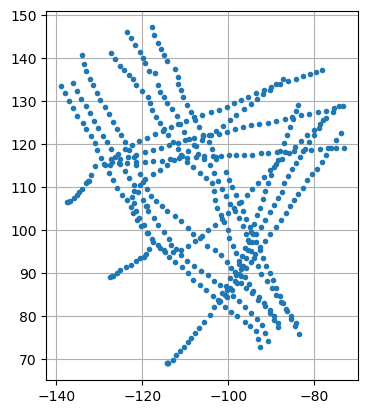

In [30]:
fig, ax, = plt.subplots()
ax.plot(pg.x(data), pg.y(data), ".")
ax.grid()
ax.set_aspect(1.0)

Before using the ready-made functions, we go through it step by step:
First, we determine the indices for forward and backward measurements
and generate a crossplot.

In our case, we have a number of 6143 pairs, large enough for any
statistical analyses, plus 4190 single data.

6143 4190


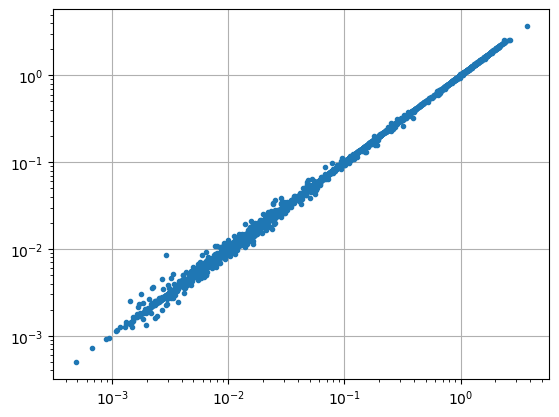

In [31]:
iF, iB = ert.reciprocalIndices(data, True)
print(len(iF), data.size()-len(iF)-len(iB))
fig, ax = plt.subplots()
ax.loglog(data['r'][iF], data['r'][iB], '.')
ax.grid()

Except some single outliers, all data are aligned along the identity axis.
We look at reciprocal errors a bit more in detail:

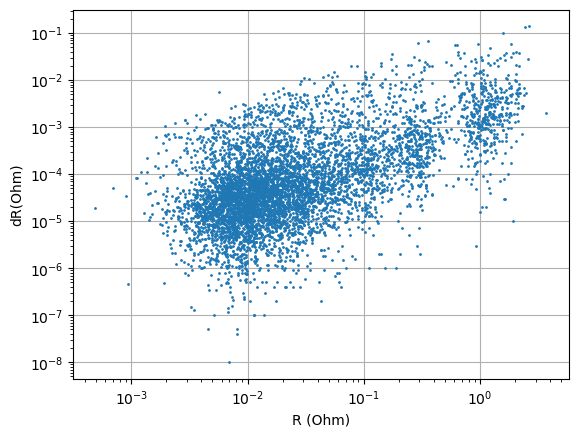

In [32]:
R = data['r']
Rmean = abs(R[iF] + R[iB]) / 2
dR = abs(R[iF] - R[iB])
fig, ax = plt.subplots()
ax.loglog(Rmean, dR, '.', markersize=2)
ax.set_xlabel('R (Ohm)')
ax.set_ylabel('dR(Ohm)')
ax.grid()

This plot rather suggests a log-log dependence
$$\log\delta R = \log a + b \log R \quad\Rightarrow\quad \delta R = a R^b $$
as it was suggested by Flores-Oroczo et al. (2018) for phase data.

Alternatively, we can plot the relative error on the y axis.

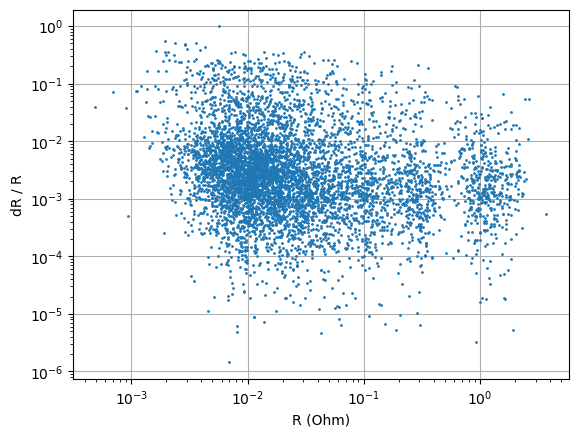

In [33]:
dRbyR = dR / Rmean
fig, ax = plt.subplots()
ax.loglog(Rmean, dRbyR, '.', markersize=2)
ax.set_xlabel('R (Ohm)')
ax.set_ylabel('dR / R')
ax.grid()

It shows that the majority of data pairs have errors of 1% or below.
The statistical analysis (binning, std and mean values) is done by a
dedicated function `fitReciprocalModel` that can also plot it all.
Note that the function also takes different signs (here all R are
positive) and possible NaN values into account.

[0.00079271 0.01098524]


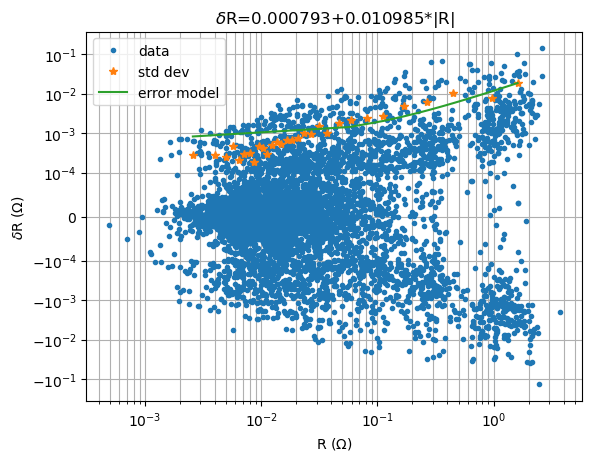

In [34]:
ab1, ax = ert.fitReciprocalErrorModel(data, show=True)
print(ab1)
ax.set_yscale("symlog", linthresh=0.0001)

Here, we end up with $b\approx$ 1% and $a\approx$ 0.8 mOhm.

Alternatively, we can fit the relative errors by `rel=True`.
This yields values of about 2.5% and 0.2 mOhm, here the first
one is more realistic but the second appears rather low.

[0.0237993  0.00018575]


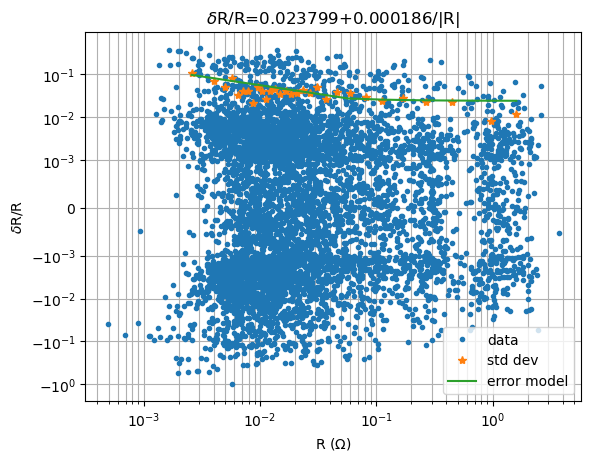

In [35]:
ab2, ax = ert.fitReciprocalErrorModel(data, rel=True, show=True)
print(ab2)
ax.set_yscale("symlog", linthresh=0.001)

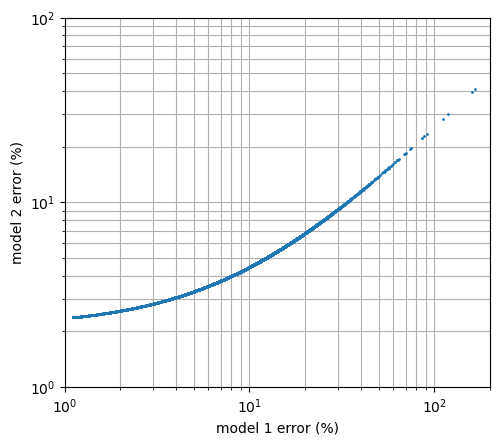

In [36]:
relerr1 = ab1[1] +  ab1[0] / data['r']
relerr2 = ab2[0] +  ab2[1] / data['r']
fig, ax = plt.subplots()
ax.loglog(relerr1*100, relerr2*100, ".", markersize=2)
ax.set_aspect(1.0)
ax.set_xlabel('model 1 error (%)')
ax.set_ylabel('model 2 error (%)')
ax.set_xlim(1, 200)
ax.set_ylim(1, 100)
ax.grid(which='both')

In this case, the second error model (2.3-40% relative error) based on fitting relative values, is more compact and appears more realistic than the first error model (1-180%) based on fitting absolute values.

## Further procedure

A N/R pair of data cannot be independently fitted. Therefore, it is reasonable to remove all values above a certail threshold as suggested by Slater et al. (2000) who used a threshold of 10% (here `sum(dRbyR>0.1)`=223 data).

Furthermore, it makes sense to keep only one quadrupole of each pair by taking the mean resistance, possibly weighted by the current strength or stacking error. This "stacking" can improve the data quality. Alternatively, one could use some heuristics to decide for one of the data and to delete the other, but this should rather be done before the N/R analysis.

The error of all data is then estimated by the used error model, optionally large individual values higher than the error model could be taken instead of these. At any rate, I suggest removing data with either large reciprocal error or large error misfits above values in the range of 20%.

All this is implemented in the function `reciprocalProcessing`.

In [40]:
out = ert.reciprocalProcessing(data)
print(out)

Data: Sensors: 515 data: 9456, nonzero entries: ['a', 'b', 'err', 'm', 'n', 'r', 'rec', 'valid']


Finally, we end up in a data container of 9456 data without any pairs.

## References

* LaBrecque, D.L., Miletto, M., Daily, W., Ramirez, A. & Owen, E. (1996): The effects of noise on Occam’s inversion of resistivity tomography data, Geophysics, 61, 538–548.
* Slater, L., A. M. Binley, W. Daily, and R. Johnson (2000): Cross-hole electrical imaging of a controlled saline tracer injection, J. Appl. Geophys., 44, 85–102, doi:10.1016/S0926-9851(00)00002-1.
* Günther, T., Rücker, C. & Spitzer, K. (2006): Three-dimensional modeling and inversion of dc resistivity data incorporating topography – II: Inversion. Geophys. J. Int. 166, 506-517, doi:10.1111/j.1365-246X.2006.03011.x.
* Koestel, J., Kemna, A., Javaux, M., Binley, A. & Vereecken, H. (2008): Quantitative imaging of solute transport in an unsaturated and undisturbed soil monolith with 3-D ERT and TDR, Water Resour. Res., 44, W12411, doi:10.1029/2007WR006755.
* Udphuay, S., Günther, T., Everett, M.E., Warden, R.R. & Briaud, J.-L. (2011): Three-dimensional resistivity tomography in extreme coastal terrain amidst dense cultural signals: application to cliff stability assessment at the historic D-Day site. Geophys. J. Int. 185(1), 201-220, doi:10.1111/j.1365-246X.2010.04915.x.